<a href="https://colab.research.google.com/github/klaasmeinke/CNNs-exoplanet-cartography/blob/main/Surfaces_and_Clouds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    %cd '/content/drive/MyDrive/Thesis'

%run Plotting.ipynb

import time
import random as rand

Mounted at /content/drive
/content/drive/MyDrive/Thesis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis


## Test Planets

These planets help verify that flux calculations are working properly

In [ ]:
def black_planet(points):
    colors = []
    for i in points:
        colors.append(0)
    return np.array(colors)

def white_planet(points):
    colors = []
    for i in points:
        colors.append(1)
    return np.array(colors)

def gray_planet(points):
    colors = []
    for i in points:
        colors.append(0.5)
    return np.array(colors)

def zebra_planet(points, stripes):
    colors = []
    for i in range(len(points)):
        long = cart2geo(points[i,0],points[i,1],points[i,2])[0]

        li = np.arange(-np.pi,np.pi,2*np.pi/(2*stripes))
        for j in range(stripes):
            if li[2*j] < long < li[2*j+1]:
                colors.append(1)
        if len(colors) - 1 < i: # didnt append a 1 yet
            colors.append(0)
    return np.array(colors)

def half_half(points):
    colors = []
    for p in points:
        lat = cart2geo(p[0],p[1],p[2])[1]
        if lat > 0:
            colors.append(1)
        else:
            colors.append(0)
    return np.array(colors)

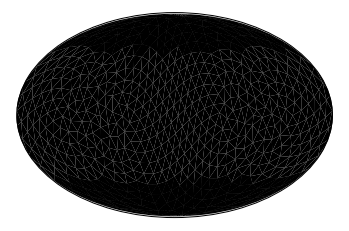

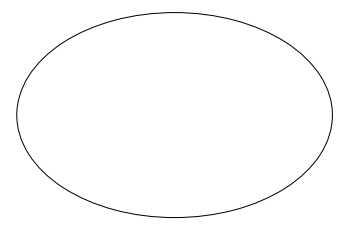

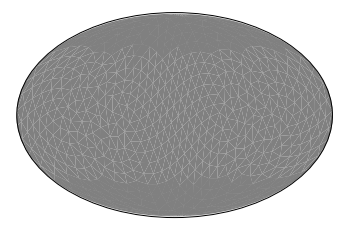

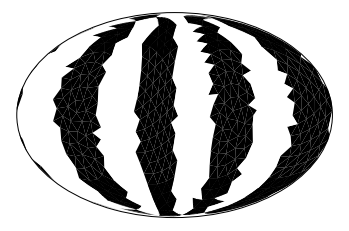

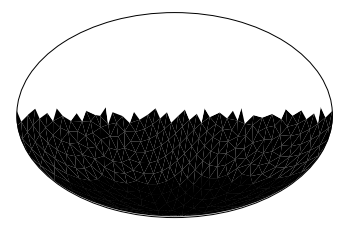

In [ ]:
# for colors in [black_planet(points), white_planet(points), gray_planet(points), \
#                zebra_planet(points,4), half_half(points)]:
#     mollweide(faces, colors)

## Tetrahedral Subdivision Method

#### Some Basic Geometry Functions:

now I know that I should have done all of this in numpy to make it much faster

In [ ]:
# convert from spherical to cartesian coordinates:
def sphere2cart(r, phi, theta):
    # output: [x,y,z]
    return([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(phi)])

# rotation using the Rodrigues Rotation Formula:
def rotate(vector, axis, theta):
    v = np.array(vector)
    k = np.array(axis)/np.linalg.norm(axis) # normalize
    return(v*np.cos(theta)+np.cross(k,v)*np.sin(theta)+ k*(np.dot(k,v))*(1-np.cos(theta)))

def distance(p1,p2):
    # function works in cartesian coordinates
    # inputs should be list: [x,y,z]
    return(((p1[0]-p2[0])**2+(p1[1]-p2[1])**2+(p1[2]-p2[2])**2)**0.5)

#### Create Tetrahedron

vx is a list of 4 vertices <br>
each vertex has format: [[x,y,z], seed, altitude] <br>
the vertices are in pyramid directions with random radius between 4 and 4.5

In [ ]:
def new_tet():

    phi = [0,2/3*np.pi,2/3*np.pi,2/3*np.pi]
    theta = [0, 0, 2/3*np.pi, 4/3*np.pi]

    vx = [] # vertices

    for i in range(4):
        time.sleep(1e-5) # to ensure time changes before next seed
        rand.seed(time.time()) # the seed to create the seed

        seed = rand.randint(0,99)
        rand.seed(seed)

        coordinates = sphere2cart(4+0.5*rand.random(), phi[i], theta[i])
        altitude = rand.random()

        vx.append([coordinates,seed,altitude])

    axis = 1 - 2*np.random.rand(3)
    theta = 2*np.pi*rand.random()
    for i in range(len(vx)):
        vx[i][0] = list(rotate(vx[i][0], axis, theta))

    return(vx)

#### Order vertices such that the first two vertices share the longest edge
orders vx such that first two vertices have the longest edge <br>
vx is a list of 4 vertices <br>
each vertex has format: [[x,y,z], seed, altitude] <br>

In [ ]:
def reorder(vx):
    longest_edge = distance(vx[0][0],vx[1][0])

    for combo in [[vx[0],vx[2]], [vx[0],vx[3]], [vx[1],vx[2]], [vx[1],vx[3]], [vx[2],vx[3]]]:
        l = distance(combo[0][0],combo[1][0])

        if l > longest_edge:
            longest_edge = l

            vx.remove(combo[0])
            vx.remove(combo[1])
            vx.insert(0,combo[0])
            vx.insert(0,combo[1])

    return(vx)

#### Create a new vertex at mid-point of longest edge

In [ ]:
def new_vertex(vx):
    # coordinates
    coordinates = []
    for i in range(3):
        coordinates.append((vx[0][0][i]+vx[1][0][i])/2)

    # seed
    seed = (vx[0][1]+vx[1][1])/2
    rand.seed(seed)

    # altitude
    offset_constant = 0.8 # increase for more randomness
    offset_exp = 0.5 # should be less than 1. smaller = less features
    a = (vx[0][2]+vx[1][2])/2
    longest_edge = distance(vx[0][0],vx[1][0])
    offset = offset_constant *longest_edge**offset_exp *abs(vx[0][2]-vx[1][2])
    a += offset

    # put it all together to right format
    return([coordinates,seed,a])

#### Check if point is inside the new tetrahedron

method from: http://steve.hollasch.net/cgindex/geometry/ptintet.html <br>
p is the point and v are the vertices <br>
each input should be a list: [x,y,z]

In [ ]:
def inside(p,v1,v2,v3,v4):

    p = [p[0], p[1], p[2], 1]
    v1 = [v1[0], v1[1], v1[2], 1]
    v2 = [v2[0], v2[1], v2[2], 1]
    v3 = [v3[0], v3[1], v3[2], 1]
    v4 = [v4[0], v4[1], v4[2], 1]

    D0 = np.linalg.det(np.array([v1, v2, v3, v4]))
    D1 = np.linalg.det(np.array([p, v2, v3, v4]))
    D2 = np.linalg.det(np.array([v1, p, v3, v4]))
    D3 = np.linalg.det(np.array([v1, v2, p, v4]))
    D4 = np.linalg.det(np.array([v1, v2, v3, p]))

    D = [D0,D1,D2,D3,D4]

    if min(D)*max(D) > 0: # checking if all Ds are the same sign
        return(True)
    else:
        return(False)

#### Find the altitude of a point on the surface:

input normal should be equal in magntitude to the area of the face

In [ ]:
def find_a(p,edge,tet_0):
    tet = tet_0[:]
    while distance(tet[0][0],tet[1][0]) > edge:
        tet = reorder(tet)
        vm = new_vertex(tet)
        if inside(p,tet[0][0],vm[0],tet[2][0],tet[3][0]):
            tet[1] = vm
        else:
            tet[0] = vm

    a = (tet[0][2]+tet[1][2]+tet[2][2]+tet[3][2])/4
    return a

## Gray-Scale Planet

#### Create altitude profile

In [ ]:
def elevation_map(points, edges):
    # random tetrahedron:
    tet_0 = new_tet()
    heights = []
    for i in range(len(points)):
        a = find_a(points[i],edges[i],tet_0)
        heights.append(a)

    return np.array(heights)

#### Create Planet

In [ ]:
def gray_scale(points, edges):
    elevations = elevation_map(points, edges)
    elevations /= (max(elevations) - min(elevations))
    elevations -= min(elevations)

    cmap = plt.get_cmap('gist_rainbow')
    colors = cmap(elevations)

    # return elevations
    return colors

[Text(1, 0, ' lowest \n elevation'), Text(1, 0, ' highest \n elevation')]

<Figure size 648x216 with 0 Axes>

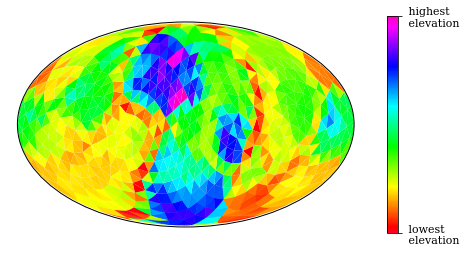

In [ ]:
# colors = gray_scale(points, edges)

# fig = plt.figure(figsize = (9,3))

# mollweide(faces, colors)

# sm = plt.cm.ScalarMappable(cmap = plt.get_cmap('gist_rainbow'))

# cbar = plt.colorbar(sm)

# cbar.set_ticks([0,1])
# cbar.ax.set_yticklabels([' lowest \n elevation', ' highest \n elevation'], fontsize = 11)

# # set_yticklabels(ticklabs, fontsize=10)

<Figure size 648x216 with 0 Axes>

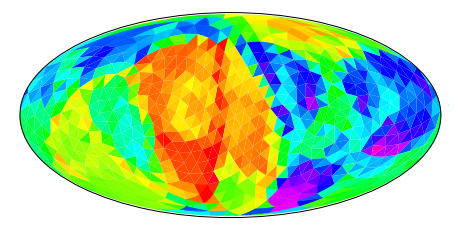

In [ ]:
# colors = gray_scale(points, edges)

# fig = plt.figure(figsize = (9,3))

# mollweide(faces, colors)

## Black and White Planet

In [ ]:
def black_and_white(points, edges):

    heights = elevation_map(points, edges)

    # SURFACE TYPES:
    black_percent = 100*rand.random()
    black_level = np.percentile(heights, black_percent) # all below this are black

    colors = []

    for i in range(len(points)):
        if heights[i] < black_level:
            colors.append(0)
        else:
            colors.append(1)

    return np.array(colors)

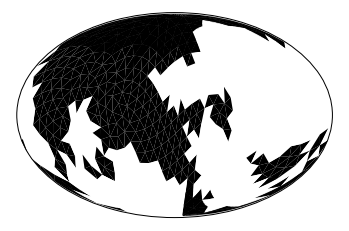

In [ ]:
# colors = black_and_white(points, edges
# mollweide(faces, colors)

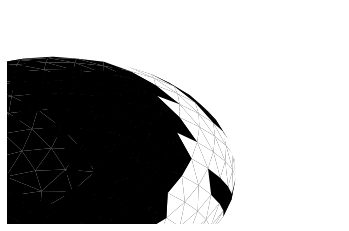

In [ ]:
# colors = black_and_white(points, edges)
# plot_3d(faces, colors)

## Green Blue White Planet
#### Generate 3 random numbers that sum to 1

In [ ]:
def rand3():
    a = np.random.rand()**2
    b = (1 - a) * (1 + np.sin(np.pi*(np.random.rand()-0.5)))/2
    c = 1 - b - a
    return a, b, c

covariance matrix:
[[ 0.08829 -0.04441 -0.04388]
 [-0.04441  0.08862 -0.04421]
 [-0.04388 -0.04421  0.08809]]


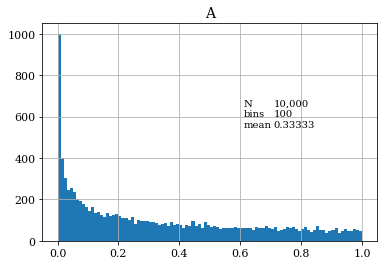

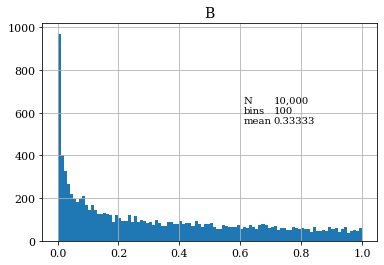

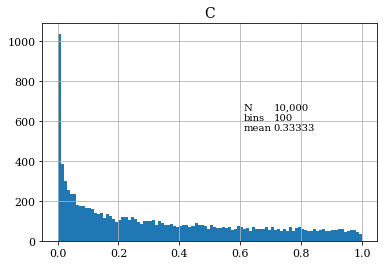

In [ ]:
# rands = np.array([rand3() for i in range(10000)])

# print('covariance matrix:')
# print(np.round(np.cov([rands[:,0],rands[:,1],rands[:,2]]), decimals = 5 ))

# axes = ['A','B','C']
# bins = 100

# labels = ['N', 'bins', 'mean']
# label_txt = ''
# for label in labels:
#     label_txt += label + '\n'

# for i in range(3):
#     fig = plt.figure()
#     fig.set_facecolor('white')
#     plt.grid()
#     plt.title(axes[i])
#     plt.hist(rands[:,i], bins = bins)


#     vals = ["{:,}".format(len(rands)), bins, np.mean(rands)]



#     val_txt = ''
#     for val in vals:
#         if type(val) in [float, np.float32, np.float64]:
#             val = '%.5f' %val
#         val_txt += str(val) + '\n'

#     plt.text(0.61, 500, label_txt)
#     plt.text(0.71, 500, val_txt)

#     plt.show()

#### Create Planet

In [ ]:
def green_blue_white(points,edges):

    heights = elevation_map(points, edges)
    cap_frac, ocean_frac, land_frac = rand3()

    # finding the altitudes and lattitudes that correspond to each type:
    cap_z = np.percentile(np.absolute(points[:,2]), 100*(1-cap_frac)) # all abs(z) above this are ice cap
    no_cap_heights = [] # list of heights of all pixels not under a cap

    for i in range(len(points)):
        if abs(points[i,2]) < cap_z:
            no_cap_heights.append(heights[i])

    ocean_level = np.percentile(no_cap_heights, 100*ocean_frac/(ocean_frac+land_frac))

    # assigning colors:
    colors = []
    for i in range(len(points)):
        if abs(points[i,2]) > cap_z:
            colors.append([1,1,1])
        else:
            if heights[i] < ocean_level:
                colors.append([0,0.8,0])
            else: colors.append([0,0,1])

    return(colors)

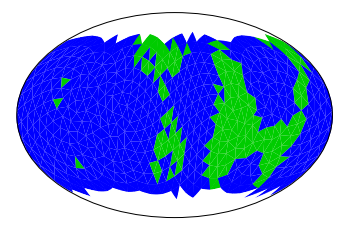

In [ ]:
# colors = green_blue_white(points, edges)
# mollweide(faces, colors)

## Green Yellow and Blue Planet
ocean: [0.05, 0.1, 0.2] <br>
desert: [0.5, 0.4, 0.15] <br>
vegetation: [0.15, 0.4, 0.15] <br>

In [ ]:
def green_yellow_blue(points,edges):

    heights = elevation_map(points, edges)
    green_frac, yellow_frac, blue_frac = rand3()

    ocean_level = np.percentile(heights, blue_frac*100) # all below this are black
    veg_level = np.percentile(heights, (blue_frac+yellow_frac)*100)

    colors = []

    for i in range(len(points)):
        if heights[i] < ocean_level:
            colors.append([0.05, 0.1, 0.2])
        elif heights[i] < veg_level:
            colors.append([0.5, 0.4, 0.15])
        else:
            colors.append([0.15, 0.4, 0.15])

    return np.array(colors)

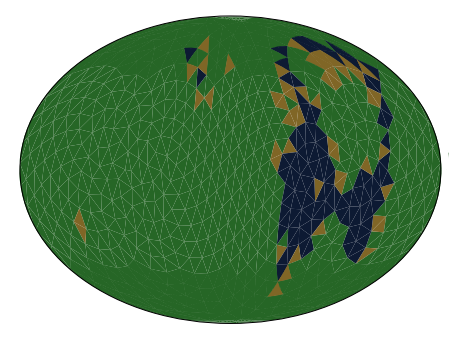

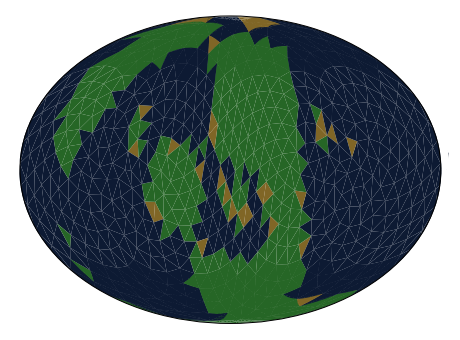

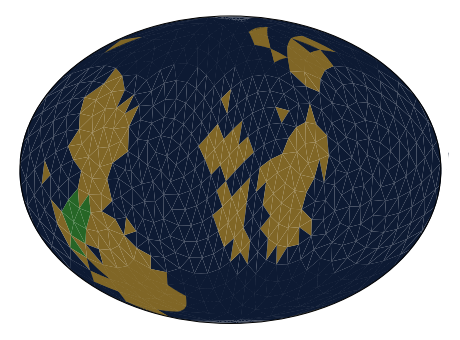

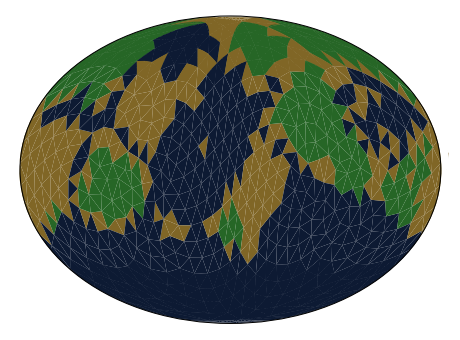

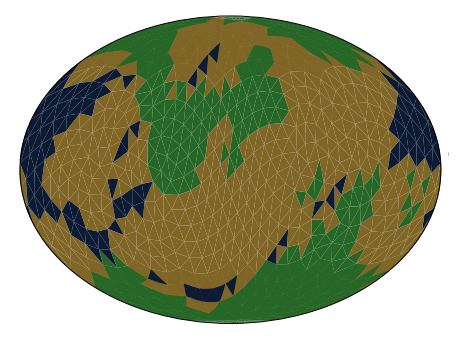

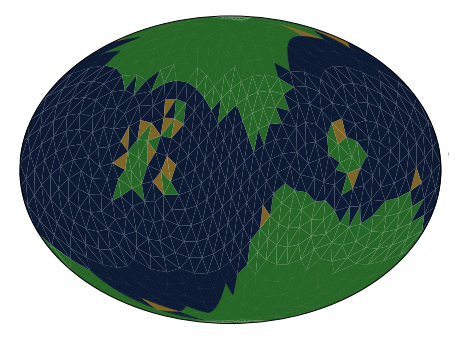

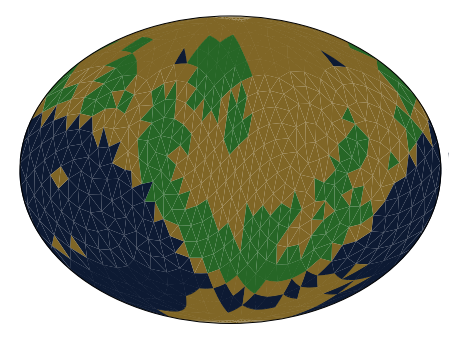

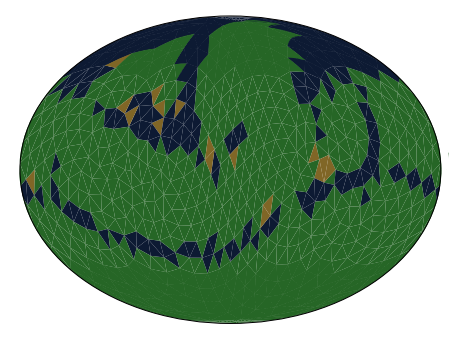

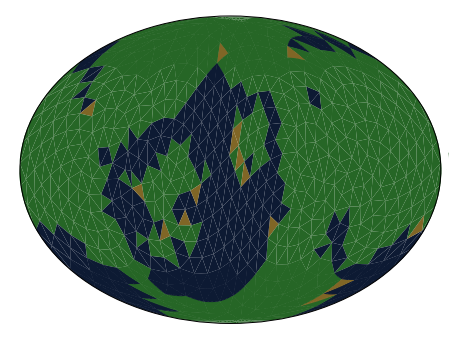

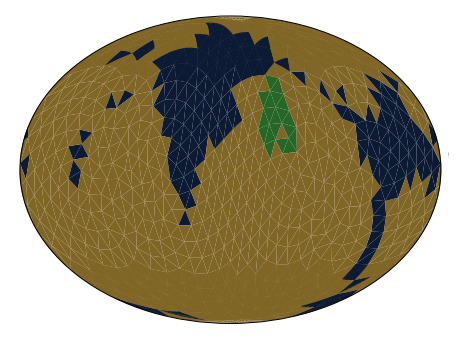

28.851670742034912


In [ ]:
# t0 = time.time()
# for i in range(10):
#     colors = green_yellow_blue(points, edges)
#     mollweide(faces, colors)

# print(time.time()-t0)

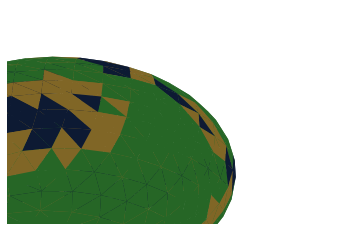

In [ ]:
# colors = green_yellow_blue(points, edges)
# plot_3d(faces, colors)

## Clouds
#### Create Cloud Pattern

In [ ]:
def closest_point(point, points):
    # returns the index of the closest points in the list "points" to "point"
    dist = [np.linalg.norm(point - points[i]) for i in range(len(points))]
    return np.argmin(dist)

def cloud_pattern(cloud_frac, points):
    #cf is the cloud fraciont

    colors = [0 for i in range(len(points))]
    points = [cart2geo(p[0], p[1], p[2]) for p in points]

    cf = 0

    while cf < cloud_frac:
        # center of cloud in longitude-lattitude coordinates
        center = rand.choice(points)

        covariance = np.array([[0.15, 0],[0, 0.003]])

        for p in np.random.multivariate_normal(center, covariance, 100):
            if np.sum(colors)/1000 >= cloud_frac:
                break
            idx = closest_point(p, points)
            colors[idx] = 1
            cf = colors.count(1)/len(colors)

    return colors

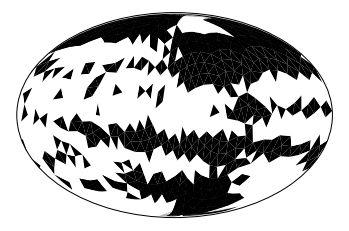

number of cloud facets:  550.0
time [s]:  27.6


In [ ]:
# t0 =  time.time()
# colors = cloud_pattern(0.55, points)

# mollweide(faces, colors)
# print('number of cloud facets: ', np.sum(colors)/3)
# print('time [s]: ', np.round(time.time()-t0, 1))

#### Combine with Surface

In [ ]:
# def combine(faces, surfaces, clouds):
#     # input a list of surfaces and a list of cloud patterns

#     colors = []
#     for surface, c in zip(surfaces, clouds):
#         colors2 = fix_colors(faces, surface)
#         for i in range(len(c)):
#             if c[i] == 1:
#                 colors2[i] = [0.8,0.8,0.8]
#         colors.append(colors2)

#     return np.array(colors)

def combine(surface_pattern, cloud_pattern):
    return np.maximum(surface_pattern, 3*cloud_pattern)

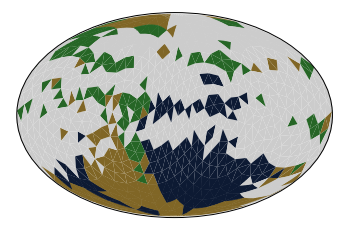

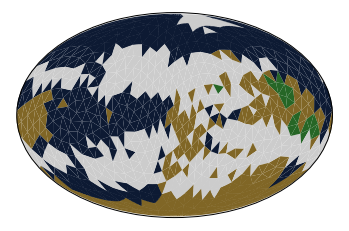

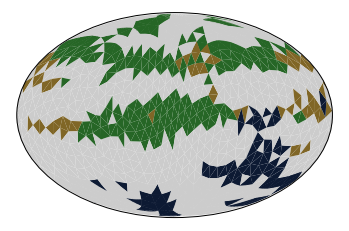

In [ ]:
# plot = 3

# faces = faces
# surfaces = np.load('data/surfaces_color.npy')[:plot]
# clouds = clouds[:plot]

# albedos = combine(faces, surfaces, clouds)

# for i in range(plot):
#     mollweide(faces, albedos[i])

## Create New Surfaces and Clouds:

In [ ]:
def add_surfaces(add):
    points = points
    edges = edges
    faces = faces

    # load existing file
    if os.path.exists('surfaces.npy'):
        surfaces = np.load('surfaces.npy')
    else:
        surfaces = [black_and_white(points,edges)]
        add -= 1
    for i in range(add):
        surfaces = np.append(surfaces, [black_and_white(points,edges)],axis=0)

    return surfaces

In [ ]:
def add_clouds(cloud_fracs):
    points = points

    if os.path.exists('data/clouds.npy'):
        clouds = clouds
    else:
        clouds = [cloud_pattern(cloud_fracs[0], points)]
        cloud_fracs = np.delete(cloud_fracs, 0)

    for cf in cloud_fracs:
        clouds = np.append(clouds, [cloud_pattern(cf, points)], axis=0)

    return clouds